In [1]:
from __future__ import print_function, division
import librosa
import os
# Change `cuda` to `cpu` to run on CPU
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import numpy as np
import scipy
import theano
import theano.tensor as T
import lasagne
from lasagne.utils import floatX
from lasagne.layers import InputLayer, Conv1DLayer as ConvLayer
from IPython.display import Audio, display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls inputs

eminem.mp3    gettysburg.mp3  nwa.mp3	     usa.mp3
fire.mp3      imperial.mp3    russia.mp3     valkyries.mp3
futurama.mp3  lemons.mp3      spongebob.mp3


### Load style and content

In [3]:
CONTENT_FILENAME = "inputs/spongebob.mp3"
STYLE_FILENAME = "inputs/gettysburg.mp3"

In [4]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [5]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    x /= np.max(np.abs(x))
    p = np.angle(S)
    return np.log1p(np.abs( S[np.newaxis,:,:430] )), p[np.newaxis,:,:430], fs

In [95]:
a_content, p_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, p_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_content.shape[2]
N_CHANNELS = a_content.shape[1]
a_style = a_style[:, :N_CHANNELS, :N_SAMPLES]
p_style = p_style[:, :N_CHANNELS, :N_SAMPLES]

ap_content = np.concatenate([a_content, p_content], axis=1)
ap_style   = np.concatenate([a_style, p_style], axis=1)

In [96]:
print( a_content.shape )
print( ap_content.shape )

(1, 1025, 430)
(1, 2050, 430)


In [ ]:
# Code to save style audio from spectrogram + phases
#r = np.expm1(a_content)[0]
#S = np.multiply( r, np.cos(p_content) ) + np.multiply( r, np.sin(p_content) )*1j
#x = librosa.istft(S)
#librosa.output.write_wav('outputs/reconstructing_style.wav', x, fs)

### Visualize spectrograms for content and style tracks

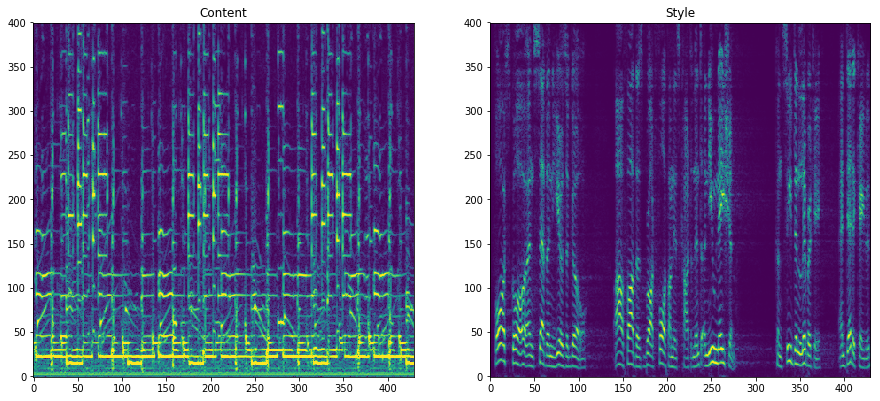

In [12]:
plt_opts = {
    'origin': 'lower',
    'vmax': 4,
    'vmin': 0
}

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[0,:400,:], **plt_opts)

plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[0,:400,:], **plt_opts)

plt.show()

### Define net

In [97]:
# During our tests, we discovered that it is essential to use extremely large number of conv filters 
# In this example we use single convolution with 4096 filters

N_FILTERS = 4096
inputs = InputLayer((1, 2*N_CHANNELS, N_SAMPLES))
W_ = lasagne.init.GlorotNormal(gain='relu').sample( (N_FILTERS, N_CHANNELS, 11) )
#W_ones = np.ones( (N_FILTERS, N_CHANNELS, 11) )

# W.shape: (N_FILTERS, 2*N_CHANNELS, 11)
conv = ConvLayer(inputs, N_FILTERS, 11, W=np.concatenate([W_,W_], axis=1))
#conv = ConvLayer(inputs, N_FILTERS, 11, W=W_)

In [98]:
content_features = lasagne.layers.get_output(conv, ap_content)
style_features = lasagne.layers.get_output(conv, ap_style)
#content_features = lasagne.layers.get_output(conv, a_content)
#style_features = lasagne.layers.get_output(conv, a_style)
# style_features.shape: (batch_n=1, N_FILTERS, N_SAMPLES-11+1)

print( lasagne.layers.get_output_shape(conv, a_content.shape) )
#print( ap_content.shape )

(1, 4096, 420)


In [99]:
# Implementation of losses and optimization is based on artistic style transfer example in lasagne recipes
# https://github.com/Lasagne/Recipes/blob/master/examples/styletransfer/Art%20Style%20Transfer.ipynb
def gram_matrix(x):
    g = T.tensordot(x, x, axes=([2], [2])) / x.shape[2]
    return g

def style_loss(A, X):
    #A_ = A[:,N_FILTERS//2:,:]
    #X_ = X[:,N_FILTERS//2:,:]
    G1 = gram_matrix(A)
    G2 = gram_matrix(X)
    loss = ((G1 - G2)**2).sum()
    return loss

def content_loss(A, X):
    #A_ = A[:,N_FILTERS//2:,:]
    #X_ = X[:,N_FILTERS//2:,:]
    return ((A - X)**2).sum()

In [100]:
generated = T.tensor3()
gen_features = lasagne.layers.get_output(conv, generated)

In [101]:
# set ALPHA=1e-3 for more style, or ALPHA=0 to turn off content entirely
ALPHA = 0
loss = style_loss(style_features, gen_features) + ALPHA * content_loss(content_features, gen_features)
grad = T.grad(loss, generated)

f_loss = theano.function([generated], loss)
f_grad = theano.function([generated], grad)

In [103]:
f_grad(ap_content).shape

(1, 2050, 430)

In [40]:
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 2*N_CHANNELS, N_SAMPLES)))
    return f_loss(x0).astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 2*N_CHANNELS, N_SAMPLES)))
    grad_evaled = f_grad(x0)
    grad_evaled[:,N_CHANNELS:,:] = grad_evaled[:,:N_CHANNELS,:]
    return np.array().flatten().astype('float64')

### Run optimization

In [ ]:
#initialization with zeros or gaussian noise can be used
#zeros don't work with ALPHA=0
t_start = floatX(np.random.randn(1, 2*N_CHANNELS, N_SAMPLES))
#t_start = floatX(np.zeros((1, 2*N_CHANNELS, N_SAMPLES)))

t_, _, _ = scipy.optimize.fmin_l_bfgs_b(eval_loss, t_start.flatten(), fprime=eval_grad, maxfun=500)
t = t_.reshape((1, 2*N_CHANNELS, N_SAMPLES))

### Invert spectrogram and save the result

In [10]:
def waveform_using_phase_from(radios, phases):
    p = phases[0]
    S = np.multiply( radios, np.cos(p) ) + np.multiply( radios, np.sin(p) )*1j
    raw = librosa.istft(S)
    return raw/np.max(np.abs(raw))

In [8]:
a = np.zeros_like(a_content[0])
p = np.zeros_like(p_content)
a[:,:] = np.expm1(t[0,:N_CHANNELS,:])
p[:,:,:] = t[:,N_CHANNELS:,:]

In [11]:
x = waveform_using_phase_from(a, p)
#x /= np.max(np.abs(x))
OUTPUT_FILENAME = 'outputs/out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [ ]:
rawaudio_with_content_phase = waveform_using_phase_from(a, p_content)
rawaudio_with_style_phase   = waveform_using_phase_from(a, p_style)
librosa.output.write_wav('outputs/out_with_content_phase.wav', rawaudio_with_content_phase, fs)
librosa.output.write_wav('outputs/out_with_style_phase.wav', rawaudio_with_style_phase, fs)

### Visualize spectrograms

In [ ]:
plt_opts = {
    'origin': 'lower',
    'vmax': 3,
    'vmin': 0
}

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.title('Content')
plt.imshow(a_content[0,:400,:], **plt_opts)

plt.subplot(2,3,2)
plt.title('Style')
plt.imshow(a_style[0,:400,:], **plt_opts)

plt.subplot(2,3,3)
plt.title('Result with no phase')
plt.imshow(np.abs(a[:400,:]), **plt_opts)
#plt.imshow(np.log1p(np.abs(librosa.stft(a_with_content_phase, N_FFT)))[:400,:], **plt_opts)
#plt.imshow(a[:400,:], **plt_opts)

plt.subplot(2,3,4)
plt.title('Result with content phase')
a_with_content_phase = np.log1p(np.abs(librosa.stft(rawaudio_with_content_phase, N_FFT)))
plt.imshow(a_with_content_phase[:400,:], **plt_opts)

plt.subplot(2,3,5)
plt.title('Result with style phase')
a_with_style_phase = np.log1p(np.abs(librosa.stft(rawaudio_with_style_phase, N_FFT)))
plt.imshow(a_with_style_phase[:400,:], **plt_opts)

plt.subplot(2,3,6)
plt.title('Result with reconstructed phase')
a_with_recon_phase = np.log1p(np.abs(librosa.stft(x, N_FFT)))
plt.imshow(a_with_recon_phase[:400,:], **plt_opts)

plt.show()